In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.6 MB/s eta 0:00:00


# Task 3: Quanvolutional Neural Networks

This implementation demonstrates the key steps in creating and evaluating a Quanvolutional Neural Network for MNIST classification. It showcases the integration of quantum and classical computing techniques.

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In this step, we import the required libraries:

* PennyLane for quantum computing
* NumPy for numerical operations
* TensorFlow and Keras for classical neural networks
* Matplotlib for visualization

In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers in quantum circuit
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Here, we define the main hyperparameters of our model:

* Number of training epochs
* Number of random layers in our quantum circuit
* Size of training and test datasets
* Random seeds for reproducibility

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In this step, we:

1. Load the MNIST dataset
2. Reduce the dataset size for faster processing
3. Normalize pixel values to the range [0, 1]
4. Add an extra dimension for convolution channels

In [ ]:
dev = qml.device("default.qubit", wires=4)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

Here, we define our quantum circuit:

1. Initialize a 4-qubit device
2. Create random parameters for the circuit
3. Define the circuit structure:
  * Encode 4 classical input values using RY rotations
  * Apply random layers
  * Measure the expectation values of Pauli-Z for each qubit

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2x2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

This function implements the quantum convolution:

1. Create an output array with reduced dimensions
2. Iterate over 2x2 squares in the input image
3. Process each 2x2 square with the quantum circuit
4. Assign the circuit outputs to different channels of the output pixel

In [ ]:
def preprocess_dataset(images):
    q_images = []
    for idx, img in enumerate(images):
        print(f"Processing image {idx + 1}/{len(images)}", end="\r")
        q_images.append(quanv(img))
    return np.asarray(q_images)

q_train_images = preprocess_dataset(train_images)
q_test_images = preprocess_dataset(test_images)

In this step, we apply the quantum convolution to all images in our dataset by defining a function to preprocess a set of images that is applied to both training and test datasets.

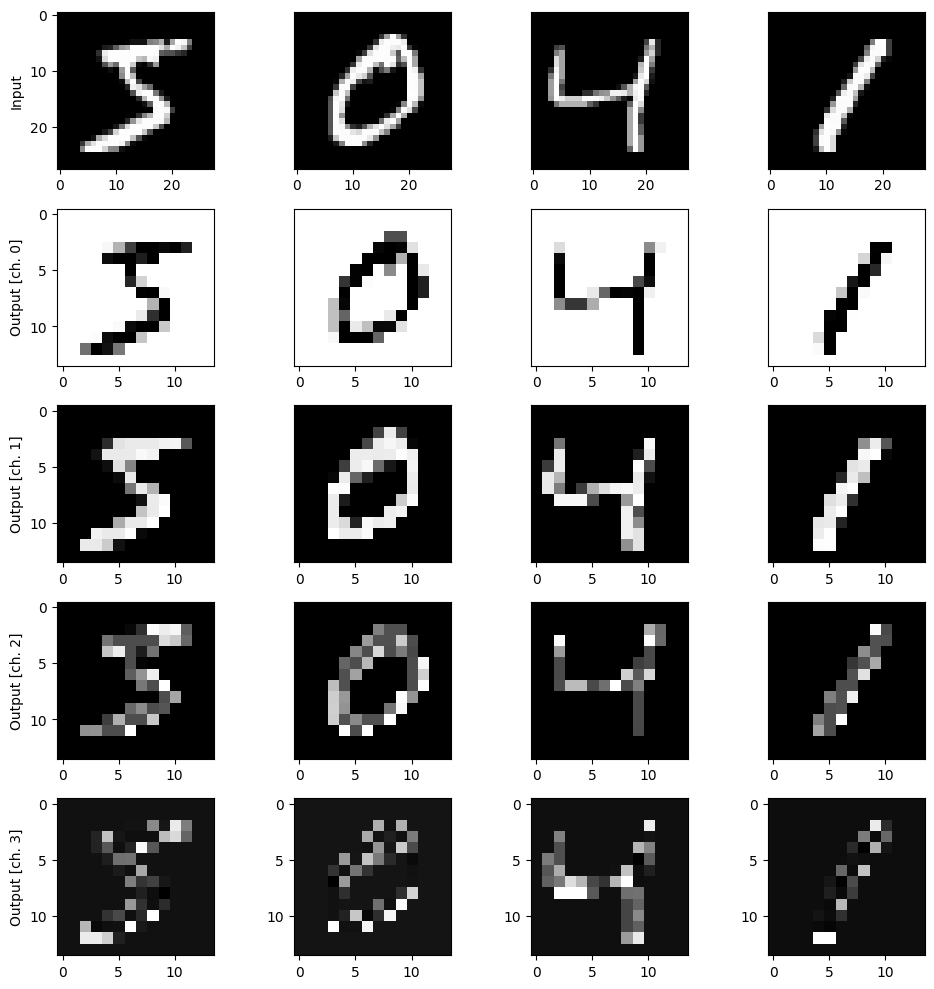

In [ ]:
def visualize_quantum_convolution(original_images, quantum_images, n_samples=4):
    n_channels = 4
    fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
    for k in range(n_samples):
        axes[0, 0].set_ylabel("Input")
        if k != 0:
            axes[0, k].yaxis.set_visible(False)
        axes[0, k].imshow(original_images[k, :, :, 0], cmap="gray")

        # Plot all output channels
        for c in range(n_channels):
            axes[c + 1, 0].set_ylabel(f"Output [ch. {c}]")
            if k != 0:
                axes[c, k].yaxis.set_visible(False)
            axes[c + 1, k].imshow(quantum_images[k, :, :, c], cmap="gray")

    plt.tight_layout()
    plt.show()

visualize_quantum_convolution(train_images, q_train_images)

This function helps us visualize the effect of the quantum convolution; displaying original images and showing the 4 output channels for each processed image.

In [ ]:
def create_hybrid_model():
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Here, we define the classical part of our hybrid model:

1. A flatten layer to convert 2D images to 1D vectors
2. A dense layer with softmax activation for classification
3. Compile the model with Adam optimizer and cross-entropy loss

In [ ]:
q_model = create_hybrid_model()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

# For comparison, train a classical model without quantum preprocessing
c_model = create_hybrid_model()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 85ms/step - accuracy: 0.1000 - loss: 2.8826 - val_accuracy: 0.2333 - val_loss: 2.3877
Epoch 2/30
13/13 - 0s - 6ms/step - accuracy: 0.3000 - loss: 2.0020 - val_accuracy: 0.2333 - val_loss: 2.2134
Epoch 3/30
13/13 - 0s - 11ms/step - accuracy: 0.4800 - loss: 1.6863 - val_accuracy: 0.4000 - val_loss: 1.8863
Epoch 4/30
13/13 - 0s - 10ms/step - accuracy: 0.7000 - loss: 1.3756 - val_accuracy: 0.5000 - val_loss: 1.7348
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.8400 - loss: 1.1447 - val_accuracy: 0.5333 - val_loss: 1.6403
Epoch 6/30
13/13 - 0s - 5ms/step - accuracy: 0.9400 - loss: 0.9609 - val_accuracy: 0.6000 - val_loss: 1.5447
Epoch 7/30
13/13 - 0s - 6ms/step - accuracy: 0.9600 - loss: 0.8097 - val_accuracy: 0.6000 - val_loss: 1.4631
Epoch 8/30
13/13 - 0s - 10ms/step - accuracy: 0.9800 - loss: 0.6886 - val_accuracy: 0.6667 - val_loss: 1.3987
Epoch 9/30
13/13 - 0s - 10ms/step - accuracy: 0.9800 - loss: 0.5896 - val_accuracy: 0.6667 - val_loss: 1.3454
Epoch 10/30
13

In this step, we:

1. Create and train the hybrid model using quantum-preprocessed images
2. Create and train a classical model using original images for comparison

Finally, we visualize and compare the results:

<ipython-input-14-bde7aba8b711>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


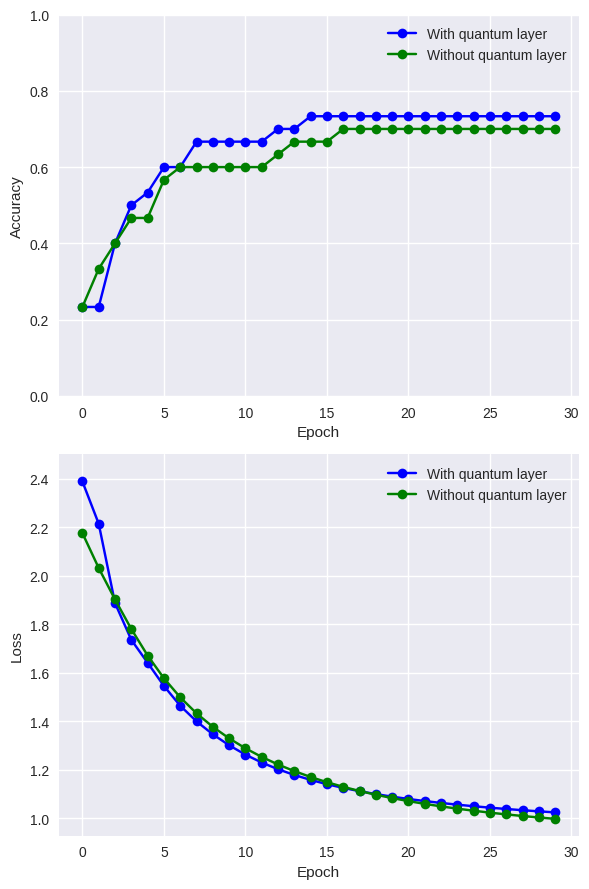

In [ ]:
def plot_training_results(q_history, c_history):
    plt.style.use("seaborn")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

    ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
    ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0, 1])
    ax1.set_xlabel("Epoch")
    ax1.legend()

    ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
    ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
    ax2.set_ylabel("Loss")
    ax2.set_ylim(top=2.5)
    ax2.set_xlabel("Epoch")
    ax2.legend()
    plt.tight_layout()
    plt.show()

plot_training_results(q_history, c_history)

## Analysis of Results

After training both the quantum-enhanced model and the classical model, we plotted their performance metrics over the training epochs.

### Accuracy Plot (Top Graph)

The top graph shows the validation accuracy of both models over the training epochs.

- **Initial Performance**: Both models start with similar low accuracy (around 0.2-0.3), which is expected as the models are untrained.

- **Early Epochs (0-5)**: The quantum model (blue line) shows faster initial improvement, reaching higher accuracy levels more quickly than the classical model (green line).

- **Mid-range Epochs (5-15)**: The quantum model maintains a slight edge in accuracy, though both models continue to improve.

- **Later Epochs (15-30)**: Both models converge to similar accuracy levels, with the quantum model maintaining a marginal lead. The final accuracy for both models is around 0.75, with the quantum model slightly higher.

- **Stability**: The quantum model's accuracy curve shows more fluctuations, particularly in the early and mid-range epochs, suggesting that the quantum layer might introduce some variability in the learning process.

### Loss Plot (Bottom Graph)

The bottom graph depicts the validation loss for both models over the training epochs.

- **Initial Loss**: The quantum model starts with a higher loss, but quickly reduces it in the first epoch.

- **Early Epochs (0-5)**: Both models show rapid decrease in loss, with the quantum model achieving slightly lower loss values.

- **Mid-range to Later Epochs (5-30)**: The loss curves for both models are very similar, with minor fluctuations. By the end of training, both models achieve comparable loss values, with the quantum model having a marginally lower loss.

### Key Observations

1. **Faster Initial Learning**: The quantum layer appears to enable faster initial learning, as evidenced by the quicker accuracy increase and loss decrease in early epochs.

2. **Comparable Final Performance**: By the end of training, both models achieve similar performance levels, with the quantum model having a slight edge in both accuracy and loss.

3. **Stability vs. Variability**: The classical model shows smoother learning curves, while the quantum model exhibits more fluctuations, especially in accuracy. This could indicate that the quantum layer introduces some randomness or complexity to the learning process.

4. **Convergence**: Both models seem to converge by the end of 30 epochs, suggesting that the chosen number of epochs was sufficient for this task and dataset size.

## Conclusion

The integration of a quantum layer in the neural network appears to be promising, particularly in enabling faster initial learning. However, for this specific task and dataset, the long-term performance gains are modest. This experiment demonstrates the potential of quantum-classical hybrid models.

These results provide a foundation for further exploration of quantum-enhanced machine learning techniques and their potential advantages in specific scenarios.
